Starting simulation...
Target: 45.0 deg | Start: 0.0 deg
Step 0: Angle=0.00, Error=45.00, Control=0.00
Step 10: Angle=5.00, Error=40.00, Control=0.00
Step 20: Angle=10.00, Error=35.00, Control=0.00
Step 30: Angle=15.00, Error=30.00, Control=-0.00
Step 40: Angle=20.00, Error=25.00, Control=0.00
Step 50: Angle=22.45, Error=22.05, Control=-4.98
Step 60: Angle=24.92, Error=19.59, Control=-4.85
Step 70: Angle=27.32, Error=17.19, Control=-4.99
Step 80: Angle=29.75, Error=14.76, Control=-4.85
Step 90: Angle=32.12, Error=12.38, Control=-4.99
Step 100: Angle=34.55, Error=9.97, Control=-4.85
Step 110: Angle=36.92, Error=7.58, Control=-4.99
Step 120: Angle=39.36, Error=5.16, Control=-4.85
Step 130: Angle=41.75, Error=2.75, Control=-4.99
Step 140: Angle=43.89, Error=0.62, Control=-4.85

Simulation complete in 144 steps. Final Angle: 44.90


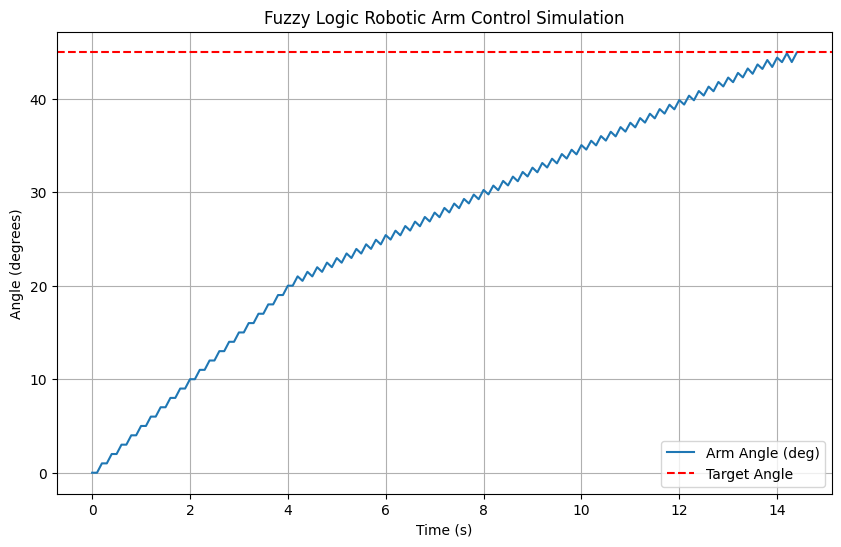

In [ ]:
#CLASSROOM CODE BY MAM

import numpy as np
import matplotlib.pyplot as plt

# --- Introduction to Fuzzy Logic Controller ---
# A Fuzzy Logic Controller (FLC) is a control system based on fuzzy logic, a
# mathematical system that analyzes analog input values in terms of logical
# variables that take on continuous values between 0 and 1, in contrast to
# classical or digital logic, which operates on discrete values of either 0 or 1.
# FLCs are often used when precise mathematical models of a system are difficult
# to obtain or when human expertise can be readily expressed in linguistic rules.
# The typical structure of an FLC involves four main components:
# 1. Fuzzification: Converts crisp (numerical) inputs into fuzzy sets (linguistic terms).
# 2. Rule Base: A set of IF-THEN rules that define the control strategy.
# 3. Inference Engine: Processes the fuzzy inputs according to the rule base to
#    determine the fuzzy output.
# 4. Defuzzification: Converts the fuzzy output back into a crisp numerical output.

# --- 1. Membership Function (MF) ---
# Membership functions define how each point in the input space is mapped to a
# membership value (degree of truth) between 0 and 1. This value indicates the
# degree to which the point belongs to a particular fuzzy set (e.g., 'Negative',
# 'Zero', 'Positive'). Triangular (trimf) and trapezoidal membership functions
# are commonly used due to their simplicity and computational efficiency.
def trimf(x, params):
    """
    Triangular membership function.
    params is a list [a, b, c] where a is the left foot, b is the peak, c is the right foot.
    - x <= a or x >= c: membership is 0 (outside the triangle's base).
    - x == b: membership is 1 (at the triangle's peak).
    - a < x < b: membership linearly increases from 0 to 1.
    - b < x < c: membership linearly decreases from 1 to 0.
    """
    a, b, c = params
    if x <= a or x >= c:
        return 0.0
    elif a < x < b:
        return (x - a) / (b - a)
    elif x == b:
        return 1.0
    elif b < x < c:
        return (c - x) / (c - b)
    return 0.0

# --- 2. Fuzzification ---
# This stage converts crisp (numerical) input values (e.g., error, change in error)
# into degrees of membership for each linguistic term (fuzzy set).
# For example, a crisp error value of 10 might have a membership of 0.8 in 'Zero'
# and 0.2 in 'Positive'.
def fuzzify(value, mfs):
    """
    Takes a crisp input value and returns a dictionary of its membership
    in each linguistic set (e.g., Negative, Zero, Positive) using the defined
    membership functions.
    """
    return {
        'Neg': trimf(value, mfs['Neg']),
        'Zero': trimf(value, mfs['Zero']),
        'Pos': trimf(value, mfs['Pos']),
    }

# --- 3. Rule Base & Inference Engine (Mamdani Type) ---
# The rule base consists of a set of IF-THEN linguistic rules that encapsulate
# human knowledge about how to control the system. The inference engine then
# interprets these rules based on the fuzzified inputs.
# Mamdani-style inference typically uses the 'min' operator for the 'AND' part
# of the IF-clause (to determine the firing strength of a rule) and the 'max'
# operator for aggregating the outputs of multiple rules that fire for the same
# output linguistic term.
def run_inference(fuzz_error, fuzz_derr):
    """
    Applies the fuzzy rule base and determines the firing strength for each rule.
    Using the Mamdani approach, the 'min' operator is used for the AND conjunction
    in the antecedent, and the 'max' operator is used for aggregation of rule
    consequents for each output linguistic set.

    Rule Base (as implied by prompt):
    1. IF Error is Negative AND dError is Negative THEN Control is Negative
    2. IF Error is Negative AND dError is Zero THEN Control is Negative
    3. IF Error is Negative AND dError is Positive THEN Control is Zero
    4. IF Error is Zero AND dError is Negative THEN Control is Negative
    5. IF Error is Zero AND dError is Zero THEN Control is Zero
    6. IF Error is Zero AND dError is Positive THEN Control is Positive
    7. IF Error is Positive AND dError is Negative THEN Control is Zero
    8. IF Error is Positive AND dError is Zero THEN Control is Positive
    9. IF Error is Positive AND dError is Positive THEN Control is Positive
    """

    # Calculate firing strength (alpha-cut) for each rule using the 'min' operator
    # for the logical AND between antecedent clauses.
    s_NN = min(fuzz_error['Neg'], fuzz_derr['Neg']) # Rule 1
    s_NZ = min(fuzz_error['Neg'], fuzz_derr['Zero']) # Rule 2
    s_NP = min(fuzz_error['Neg'], fuzz_derr['Pos']) # Rule 3

    s_ZN = min(fuzz_error['Zero'], fuzz_derr['Neg']) # Rule 4
    s_ZZ = min(fuzz_error['Zero'], fuzz_derr['Zero']) # Rule 5
    s_ZP = min(fuzz_error['Zero'], fuzz_derr['Pos']) # Rule 6

    s_PN = min(fuzz_error['Pos'], fuzz_derr['Neg']) # Rule 7
    s_PZ = min(fuzz_error['Pos'], fuzz_derr['Zero']) # Rule 8
    s_PP = min(fuzz_error['Pos'], fuzz_derr['Pos']) # Rule 9

    # Aggregate strengths for each output set (Control.Neg, Control.Zero, Control.Pos).
    # If multiple rules contribute to the same output linguistic term, the 'max'
    # operator is typically used to combine their effects. This determines how much
    # each output MF will be 'clipped'.
    output_strengths = {
        'Neg': max(s_NN, s_NZ, s_ZN), # Rules 1, 2, 4 contribute to 'Control is Neg'
        'Zero': max(s_NP, s_ZZ, s_PN), # Rules 3, 5, 7 contribute to 'Control is Zero'
        'Pos': max(s_ZP, s_PZ, s_PP)  # Rules 6, 8, 9 contribute to 'Control is Pos'
    }

    return output_strengths

# --- 4. Defuzzification (Centroid Method) ---
# This is the final stage where the fuzzy output (aggregated fuzzy set) is
# converted back into a crisp, numerical control action that can be applied to the plant.
# The Centroid (Center of Area or Center of Gravity) method is one of the most
# common defuzzification techniques. It calculates the center of gravity of the
# aggregated fuzzy output distribution.
def defuzzify_centroid(strengths, mfs, universe):
    """
    Calculates the crisp control output using the Centroid (Center of Area) method.
    This method approximates the integral by summing over a discretized output universe.

    Steps:
    1. Clip the consequent membership functions (mfs) by their respective rule firing strengths.
       For example, if 'Control is Neg' has a strength of 0.7, the 'Neg' output MF is clipped at 0.7.
    2. Aggregate these clipped membership functions using the 'max' operator to form a single
       combined fuzzy output set.
    3. Calculate the center of gravity of this combined fuzzy set.
    """
    numerator = 0.0
    denominator = 0.0

    # Iterate through the discretized output universe to approximate the integral
    for x in universe:
        # 1. Get membership grade for this x in each output MF
        mu_neg = trimf(x, mfs['Neg'])
        mu_zero = trimf(x, mfs['Zero'])
        mu_pos = trimf(x, mfs['Pos'])

        # 2. Clip the MFs at the strength calculated from inference (Mamdani implication)
        # This effectively modifies the shape of the output fuzzy sets based on how strongly
        # the rules fired.
        clipped_neg = min(strengths['Neg'], mu_neg)
        clipped_zero = min(strengths['Zero'], mu_zero)
        clipped_pos = min(strengths['Pos'], mu_pos)

        # 3. Aggregate the clipped MFs (find the final fuzzy output shape)
        # The overall fuzzy output is typically the union (max) of all clipped output MFs.
        aggregated_mu = max(clipped_neg, clipped_zero, clipped_pos)

        # 4. Calculate centroid components (sum of x * mu(x) / sum of mu(x))
        numerator += aggregated_mu * x
        denominator += aggregated_mu

    # Avoid division by zero if no rules fired or aggregation resulted in an empty set
    if denominator == 0:
        return 0.0

    return numerator / denominator

# --- 5. Plant & Simulation ---
# This section integrates the fuzzy controller into a simulation loop to mimic
# the behavior of a physical system (a robotic arm in this case). The controller
# continuously receives feedback (error, change in error) and generates control
# signals to guide the arm towards the target angle.
def simulate_arm():
    """
    Runs the main simulation loop for the fuzzy-controlled robotic arm.
    The simulation iteratively calculates error, applies fuzzy logic to determine
    control action, and updates the arm's state.
    """

    # --- Define Membership Functions for Inputs and Output ---
    # These define the fuzzy sets for 'Error', 'Change in Error' (dError),
    # and 'Control' output. The parameters [a, b, c] define the triangular MFs.
    # Universe of Discourse for Error: [-50, 50] degrees
    error_mfs = {
        'Neg': [-50, -25, 0],
        'Zero': [-25, 0, 25],
        'Pos': [0, 25, 50]
    }
    # Universe of Discourse for Change in Error: [-10, 10] degrees/sec
    derr_mfs = {
        'Neg': [-10, -5, 0],
        'Zero': [-5, 0, 5],
        'Pos': [0, 5, 10]
    }
    # Universe of Discourse for Control Output: [-20, 20] control units (e.g., torque)
    control_mfs = {
        'Neg': [-20, -10, 0],
        'Zero': [-10, 0, 10],
        'Pos': [0, 10, 20]
    }
    # Discretized universe for defuzzification to perform numerical integration (summation)
    control_universe = np.linspace(-20, 20, 100) # 100 points between -20 and 20

    # --- Simulation Parameters ---
    target_angle = 45.0  # Desired angle of the robotic arm (degrees)
    current_angle = 0.0   # Initial angle of the robotic arm (degrees)
    dt = 0.1              # Time step for the simulation (seconds)
    gain = 1.0            # Plant gain, scales the effect of the control output on the arm's movement

    # Initial error and previous error for calculating change in error
    error = target_angle - current_angle
    prev_error = 0.0

    # Simulation stop conditions
    error_threshold = 0.1 # When the absolute error is below this, consider the target reached
    max_iterations = 200  # Maximum number of simulation steps to prevent infinite loops

    # History lists for plotting simulation results
    history_angle = [current_angle]
    history_error = [error]
    history_time = [0.0]

    print("Starting simulation...")
    print(f"Target: {target_angle:.1f} deg | Start: {current_angle:.1f} deg")

    # Main simulation loop
    for i in range(max_iterations):

        # --- 1. Calculate Error and Change in Error ---
        # Error (E) is the difference between target and current state.
        # Change in Error (dE) is the rate of change of the error, indicating
        # whether the error is increasing or decreasing.
        error = target_angle - current_angle
        derr = (error - prev_error) / dt

        # Check if the arm has reached the target within the allowed threshold
        if abs(error) <= error_threshold:
            print(f"\nSimulation complete in {i} steps. Final Angle: {current_angle:.2f}")
            break

        # --- 2. Fuzzy Controller ---
        # The core of the fuzzy logic control process.
        # Fuzzify inputs: Convert crisp 'error' and 'derr' into fuzzy membership degrees.
        fuzz_error = fuzzify(error, error_mfs)
        fuzz_derr = fuzzify(derr, derr_mfs)

        # Run inference: Apply fuzzy rules to fuzzified inputs to get fuzzy output strengths.
        output_strengths = run_inference(fuzz_error, fuzz_derr)

        # Defuzzify: Convert fuzzy output strengths into a single crisp control signal.
        control = defuzzify_centroid(output_strengths, control_mfs, control_universe)

        # --- 3. Update Plant (Simulated Arm) ---
        # Apply the crisp control signal to the simulated robotic arm.
        # The 'gain' parameter determines how responsive the arm is to the control signal.
        current_angle += dt * gain * control

        # --- 4. Update State for next loop ---
        # Store the current error to calculate 'change in error' in the next iteration.
        prev_error = error

        # --- 5. Logging & History ---
        # Record important variables for later analysis and plotting.
        history_angle.append(current_angle)
        history_error.append(error)
        history_time.append(history_time[-1] + dt)

        # Print progress periodically
        if i % 10 == 0:
            print(f"Step {i}: Angle={current_angle:.2f}, Error={error:.2f}, Control={control:.2f}")

    # Message if simulation finishes due to max iterations
    if i == max_iterations - 1:
        print("\nMax iterations reached.")

    # --- Plotting Results ---
    # Visualize the arm's angle over time and its convergence towards the target.
    plt.figure(figsize=(10, 6))
    plt.plot(history_time, history_angle, label='Arm Angle (deg)')
    plt.axhline(y=target_angle, color='r', linestyle='--', label='Target Angle')
    plt.title('Fuzzy Logic Robotic Arm Control Simulation')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.grid(True)
    plt.show()


# --- Run the Simulation ---
# This block ensures that simulate_arm() is called only when the script is executed directly.
if __name__ == "__main__":
    simulate_arm()

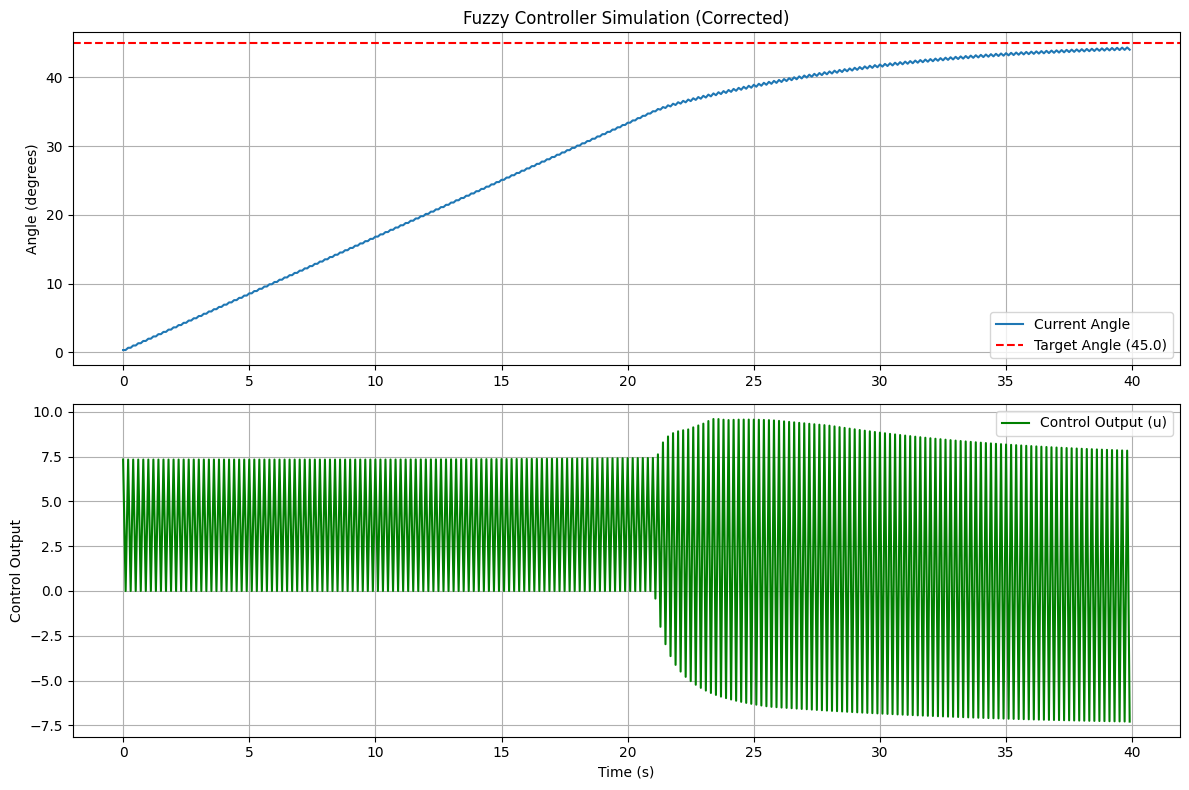

In [ ]:
#ABOVE CODE OPTIMIZED BY RUTUJ

import numpy as np
import matplotlib.pyplot as plt

# ---------- Utility: triangular membership ----------
def trimf(x, a, b, c):
    """Triangular membership function."""
    if x <= a or x >= c:
        return 0.0
    elif x == b:
        return 1.0
    elif x < b:
        return (x - a) / (b - a)
    else:
        return (c - x) / (c - b)

# ---------- Define fuzzy sets (Corrected) ----------

# --- Error MFs ---
# Left shoulder (ramp down, stays at 1 for x <= -30)
def err_neg(x):
    if x <= -30: return 1.0
    if x >= 0: return 0.0
    return (0 - x) / (0 - (-30))

# Triangle
def err_zero(x): return trimf(x, -10, 0, 10)

# Right shoulder (ramp up, stays at 1 for x >= 30)
def err_pos(x):
    if x <= 0: return 0.0
    if x >= 30: return 1.0
    return (x - 0) / (30 - 0)

# --- Delta-Error MFs ---
# Left shoulder
def derr_neg(x):
    if x <= -10: return 1.0
    if x >= 0: return 0.0
    return (0 - x) / (0 - (-10))

# Triangle
def derr_zero(x): return trimf(x, -3, 0, 3)

# Right shoulder
def derr_pos(x):
    if x <= 0: return 0.0
    if x >= 10: return 1.0
    return (x - 0) / (10 - 0)

# Control output universe for defuzzification
u_universe = np.linspace(-20, 20, 401)

# --- Control Output MFs ---
# Left shoulder
def u_sn(x):
    if x <= -20: return 1.0
    if x >= -10: return 0.0
    return (-10 - x) / (-10 - (-20))

# Triangle
def u_wn(x): return trimf(x, -15, -7, 0)
def u_z(x): return trimf(x, -3, 0, 3)
def u_wp(x): return trimf(x, 0, 7, 15)

# Right shoulder
def u_sp(x):
    if x <= 10: return 0.0
    if x >= 20: return 1.0
    return (x - 10) / (20 - 10)

# ---------- Rule evaluation (Mamdani) ----------
def evaluate_rules(e_val, de_val):
    # compute antecedent degrees
    e_neg = err_neg(e_val); e_zero = err_zero(e_val); e_pos = err_pos(e_val)
    de_neg = derr_neg(de_val); de_zero = derr_zero(de_val); de_pos = derr_pos(de_val)

    # for each rule compute firing strength and clipped consequent MF
    fired = [] # list of (strength, consequent_mf_function)

    # rules list (same logic as earlier)
    fired.append((min(e_neg, de_neg), u_sn))
    fired.append((min(e_neg, de_zero), u_wn))
    fired.append((min(e_neg, de_pos), u_z))
    fired.append((min(e_zero, de_neg), u_wn))
    fired.append((min(e_zero, de_zero), u_z))
    fired.append((min(e_zero, de_pos), u_wp))
    fired.append((min(e_pos, de_neg), u_z))
    fired.append((min(e_pos, de_zero), u_wp))
    fired.append((min(e_pos, de_pos), u_sp))

    return fired

# ---------- Defuzzify (centroid) ----------
def defuzz_centroid(combined_mf, u_univ):
    # combined_mf: list of membership values at each u_univ point
    num = np.sum(combined_mf * u_univ)
    den = np.sum(combined_mf)
    if den == 0: return 0.0
    return num / den

# ---------- Combine fired rules into aggregated MF ----------
def aggregate(fired, u_univ):
    # For each u value, aggregated membership = max over clipped consequents
    agg = np.zeros_like(u_univ)
    for strength, mf_func in fired:
        if strength <= 0: continue
        # clipped consequent MF of this rule
        vals = np.array([min(strength, mf_func(u)) for u in u_univ])
        agg = np.maximum(agg, vals)
    return agg

# ---------- Simulation ----------
target_angle = 45.0
cur_angle = 0.0
dt = 0.1
gain = 0.45
max_steps = 400
control_sat = 20.0

time_hist, angle_hist, control_hist = [], [], []
prev_error = target_angle - cur_angle

for step in range(max_steps):
    e = target_angle - cur_angle
    de = (e - prev_error) / dt

    fired = evaluate_rules(e, de)
    agg = aggregate(fired, u_universe)
    u_out = defuzz_centroid(agg, u_universe)

    # saturate
    u_out = max(min(u_out, control_sat), -control_sat)

    cur_angle += gain * u_out * dt

    time_hist.append(step * dt)
    angle_hist.append(cur_angle)
    control_hist.append(u_out)

    prev_error = e

    if abs(e) < 0.2 and abs(de) < 0.5:
        print(f"Converged at step {step}, angle={cur_angle:.3f}")
        break

# ---------- Plotting Results ----------
plt.figure(figsize=(12, 8))

# Plot 1: Angle vs. Time
plt.subplot(2, 1, 1)
plt.plot(time_hist, angle_hist, label='Current Angle')
plt.axhline(y=target_angle, color='r', linestyle='--', label=f'Target Angle ({target_angle})')
plt.title('Fuzzy Controller Simulation (Corrected)')
plt.ylabel('Angle (degrees)')
plt.legend()
plt.grid(True)

# Plot 2: Control Output vs. Time
plt.subplot(2, 1, 2)
plt.plot(time_hist, control_hist, label='Control Output (u)', color='g')
plt.xlabel('Time (s)')
plt.ylabel('Control Output')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#SAIRAJ'S CODE
def triangular_membership(x, a, b, c):
    """Calculates the membership degree for a TMF defined by points (a, b, c)."""
    if x <= a or x >= c:
        return 0.0
    elif a < x <= b:
        # Rising slope: (x - a) / (b - a)
        return (x - a) / (b - a)
    else: # b < x < c
        # Falling slope: (c - x) / (c - b)
        return (c - x) / (c - b)

def fuzzify_input(value, variable_name):
    """
    Maps a crisp input value to membership degrees for all linguistic sets.
    Returns a dictionary: {'NL': degree, 'NM': degree, ...}
    """
    sets = {}
    if variable_name == 'Error':
        # Error TMF definitions (a, b, c):
        sets['NL'] = triangular_membership(value, -10, -10, -5)
        sets['NM'] = triangular_membership(value, -7, -3, 0)
        sets['ZE'] = triangular_membership(value, -3, 0, 3)
        sets['PM'] = triangular_membership(value, 0, 3, 7)
        sets['PL'] = triangular_membership(value, 5, 10, 10)

    elif variable_name == 'Change_in_Error':
        # Change in Error TMF definitions (a, b, c):
        sets['NL'] = triangular_membership(value, -4, -4, -2)
        sets['NM'] = triangular_membership(value, -3, -1.5, 0)
        sets['ZE'] = triangular_membership(value, -1.5, 0, 1.5)
        sets['PM'] = triangular_membership(value, 0, 1.5, 3)
        sets['PL'] = triangular_membership(value, 2, 4, 4)

    # We only care about the sets with membership > 0
    return {k: v for k, v in sets.items() if v > 0}

# --- Example Fuzzification ---
current_error = 2.5  # We are 2.5 degrees away from the target
delta_error = -0.8   # We are moving towards the target at 0.8 degrees/sec

fuzzified_E = fuzzify_input(current_error, 'Error')
fuzzified_dE = fuzzify_input(delta_error, 'Change_in_Error')

print("--- Step 1: Fuzzification ---")
print(f"Crisp Error (2.5) -> {fuzzified_E}")
print(f"Crisp dError (-0.8) -> {fuzzified_dE}")
def inference_and_aggregation(fuzzified_E, fuzzified_dE):
    """Applies the Rule Base and aggregates the resulting output fuzzy set."""
    # Output Linguistic Variables (Motor Power - MP):
    # NL, NM, ZE, PM, PL (Corresponds to low to high negative/positive power)

    # Simple Rule Base: Dict of Dicts mapping (E, dE) to MP
    Rule_Base = {
        'NL': {'NL': 'PL', 'NM': 'PL', 'ZE': 'PM', 'PM': 'PM', 'PL': 'ZE'},
        'NM': {'NL': 'PL', 'NM': 'PM', 'ZE': 'PM', 'PM': 'ZE', 'PL': 'NM'},
        'ZE': {'NL': 'PM', 'NM': 'PM', 'ZE': 'ZE', 'PM': 'NM', 'PL': 'NM'},
        'PM': {'NL': 'ZE', 'NM': 'NM', 'ZE': 'NM', 'PM': 'NL', 'PL': 'NL'},
        'PL': {'NL': 'NM', 'NM': 'NL', 'ZE': 'NL', 'PM': 'NL', 'PL': 'NL'}
    }

    # Initialize the aggregated output fuzzy set (MP)
    # We only care about the five output sets: NL, NM, ZE, PM, PL
    aggregated_output = {'NL': 0.0, 'NM': 0.0, 'ZE': 0.0, 'PM': 0.0, 'PL': 0.0}

    # Iterate over all active rules (combinations of E and dE with > 0 degree)
    for E_set, mu_E in fuzzified_E.items():
        for dE_set, mu_dE in fuzzified_dE.items():

            # 1. Premise Evaluation (AND operation - MIN)
            rule_strength = min(mu_E, mu_dE)

            # 2. Rule Lookup (THEN)
            output_set = Rule_Base[E_set][dE_set]

            # 3. Aggregation (MAX operation)
            # Update the membership degree of the resulting output set 'C'
            # by taking the MAX of its current degree and the new rule's strength
            aggregated_output[output_set] = max(aggregated_output[output_set], rule_strength)

    # Filter out sets with 0 membership for simplicity
    return {k: v for k, v in aggregated_output.items() if v > 0}

# --- Example Inference and Aggregation ---
aggregated_MP = inference_and_aggregation(fuzzified_E, fuzzified_dE)

print("\n--- Step 2: Inference & Aggregation ---")
print(f"Aggregated Output (Motor Power): {aggregated_MP}")
def defuzzify_cog(aggregated_output):
    """Calculates the crisp output using the Center of Gravity (COG) method."""

    # Center points (centroids) for the Motor Power output sets
    # These represent the 'crisp' value where the set's membership is 1.0
    MP_centroids = {
        'NL': -40,  # Negative Large Power
        'NM': -20,  # Negative Medium Power
        'ZE': 0,    # Zero Power
        'PM': 20,   # Positive Medium Power
        'PL': 40    # Positive Large Power
    }

    numerator_sum = 0.0
    denominator_sum = 0.0

    # COG Formula: crisp_output = sum(mu_i * c_i) / sum(mu_i)
    # mu_i: The height of the output set (from the aggregation step)
    # c_i: The centroid of the output set
    for set_name, mu in aggregated_output.items():
        centroid = MP_centroids[set_name]

        numerator_sum += mu * centroid
        denominator_sum += mu

    if denominator_sum == 0:
        return 0.0 # Safety check: If no rules fired, no power change

    crisp_output = numerator_sum / denominator_sum
    return crisp_output

# --- Example Defuzzification ---
final_motor_power = defuzzify_cog(aggregated_MP)

print("\n--- Step 3: Defuzzification (COG) ---")
print(f"Crisp Motor Power Command: {final_motor_power:.2f} Volts/Units")

def fuzzy_logic_controller(current_error, delta_error):

    # 1. FUZZIFICATION
    fuzzified_E = fuzzify_input(current_error, 'Error')
    fuzzified_dE = fuzzify_input(delta_error, 'Change_in_Error')

    # If no membership is found for an input, the system can't fire rules.
    if not fuzzified_E or not fuzzified_dE:
        return 0.0, fuzzified_E, fuzzified_dE, {} # Return 0 power

    # 2. INFERENCE & AGGREGATION
    aggregated_MP = inference_and_aggregation(fuzzified_E, fuzzified_dE)

    # 3. DEFUZZIFICATION
    final_power = defuzzify_cog(aggregated_MP)

    return final_power, fuzzified_E, fuzzified_dE, aggregated_MP

# --- Simulation Run ---
E_sim = 2.5   # 2.5 degrees away (Positive Medium Error)
dE_sim = -0.8 # Closing the error (Negative Medium Change in Error)

power, fE, fdE, aMP = fuzzy_logic_controller(E_sim, dE_sim)

print("=====================================================")
print("  Simulated Robotic Arm Joint Control: Fuzzy Logic")
print("=====================================================")
print(f"INPUTS: Error={E_sim}, Change in Error={dE_sim}")
print("\n[Fuzzification]:")
print(f"  Error Sets: {fE}")
print(f"  dError Sets: {fdE}")
print("\n[Inference & Aggregation]:")
print(f"  Active Output Sets: {aMP}")
print("\n[Defuzzification]:")
print(f"OUTPUT COMMAND: {power:.2f} Volts (Positive power to push arm back)")
print("=====================================================")

--- Step 1: Fuzzification ---
Crisp Error (2.5) -> {'ZE': 0.16666666666666666, 'PM': 0.8333333333333334}
Crisp dError (-0.8) -> {'NM': 0.5333333333333333, 'ZE': 0.4666666666666666}

--- Step 2: Inference & Aggregation ---
Aggregated Output (Motor Power): {'NM': 0.5333333333333333, 'ZE': 0.16666666666666666, 'PM': 0.16666666666666666}

--- Step 3: Defuzzification (COG) ---
Crisp Motor Power Command: -8.46 Volts/Units
  Simulated Robotic Arm Joint Control: Fuzzy Logic
INPUTS: Error=2.5, Change in Error=-0.8

[Fuzzification]:
  Error Sets: {'ZE': 0.16666666666666666, 'PM': 0.8333333333333334}
  dError Sets: {'NM': 0.5333333333333333, 'ZE': 0.4666666666666666}

[Inference & Aggregation]:
  Active Output Sets: {'NM': 0.5333333333333333, 'ZE': 0.16666666666666666, 'PM': 0.16666666666666666}

[Defuzzification]:
OUTPUT COMMAND: -8.46 Volts (Positive power to push arm back)
